In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
# Core
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 200)
sns.set_context("notebook")

In [19]:
app = pd.read_csv('/content/drive/My Drive/My_Projects/application_record.csv')
cred = pd.read_csv('/content/drive/My Drive/My_Projects/credit_record.csv')

print("app shape:", app.shape, "| cred shape:", cred.shape)
display(app.head())
display(cred.head())

app shape: (438557, 18) | cred shape: (1048575, 3)


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


# EDA


Check missing values:

,0
OCCUPATION_TYPE,134203
ID,0
CODE_GENDER,0
FLAG_OWN_CAR,0
CNT_CHILDREN,0
FLAG_OWN_REALTY,0
NAME_INCOME_TYPE,0
NAME_EDUCATION_TYPE,0
NAME_FAMILY_STATUS,0
AMT_INCOME_TOTAL,0


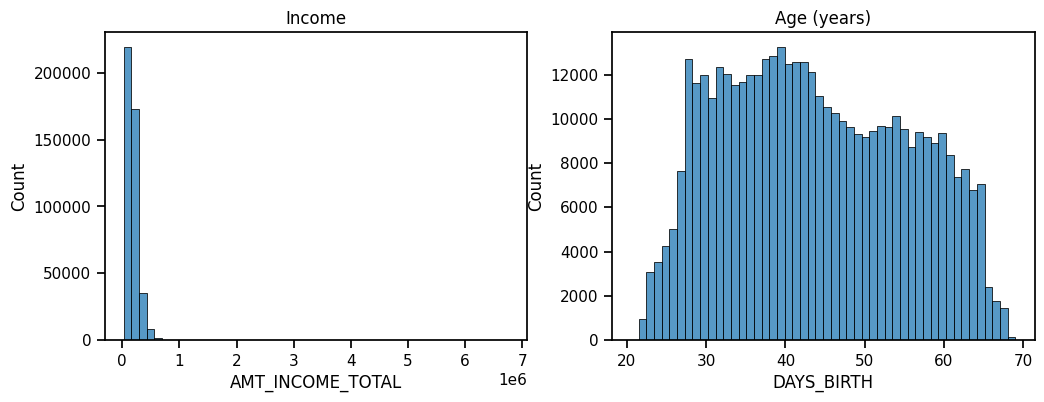

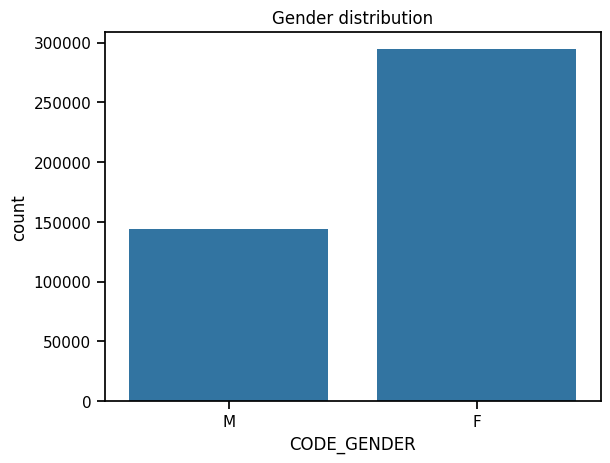

In [20]:
# Missing values (top 15)
app_nulls = app.isna().sum().sort_values(ascending=False).head(15)
display(app_nulls)

# Numeric distributions
fig, ax = plt.subplots(1,2, figsize=(12,4))
sns.histplot(app['AMT_INCOME_TOTAL'], bins=50, ax=ax[0]); ax[0].set_title("Income")
sns.histplot(-app['DAYS_BIRTH']/365.25, bins=50, ax=ax[1]); ax[1].set_title("Age (years)")
plt.show()

# Simple categorical count
sns.countplot(x='CODE_GENDER', data=app)
plt.title("Gender distribution")
plt.show()

Bar plots for categorical:

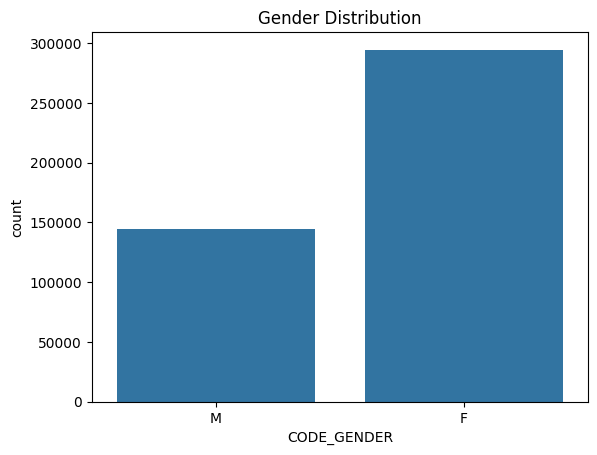

In [ ]:
sns.countplot(x='CODE_GENDER', data=app)
plt.title("Gender Distribution")
plt.show()

Vintage split (NO leakage): build features from past, label from future

In [21]:
# Clean status
cred['STATUS'] = cred['STATUS'].astype(str).str.strip()

# Choose cutoff: use history <= -6 to predict default in months > -6 (last 6 months)
CUTOFF = -6

feat_win = cred[cred['MONTHS_BALANCE'] <= CUTOFF].copy()
outc_win = cred[cred['MONTHS_BALANCE'] >  CUTOFF].copy()

status_map = {'X': -1,'C': 0,'0': 0,'1': 1,'2': 2,'3': 3,'4': 4,'5': 5}
feat_win['STATUS_NUM'] = feat_win['STATUS'].map(status_map)

# Past-window aggregates (features)
feat_agg = (feat_win
  .groupby('ID')
  .agg(
      WORST_STATUS=('STATUS_NUM','max'),
      N_BAD_MONTHS=('STATUS_NUM', lambda x: (x>=2).sum()),
      N_LATE_30=('STATUS_NUM', lambda x: (x==1).sum()),
      N_ON_TIME=('STATUS_NUM', lambda x: ((x==0)|(x==-1)).sum()),
      N_TOTAL_MONTHS=('STATUS_NUM','count'),
      FIRST_M=('MONTHS_BALANCE','min'),
      LAST_M=('MONTHS_BALANCE','max'),
  )
  .reset_index()
)
feat_agg['HIST_LEN']   = feat_agg['LAST_M'] - feat_agg['FIRST_M'] + 1
feat_agg['BAD_RATIO']  = np.where(feat_agg['N_TOTAL_MONTHS']>0,
                                  feat_agg['N_BAD_MONTHS']/feat_agg['N_TOTAL_MONTHS'], 0.0)

# Future-window label
bad_set = {'2','3','4','5'}
labels_future = (outc_win
  .assign(default_future=outc_win['STATUS'].isin(bad_set).astype(int))
  .groupby('ID', as_index=False)['default_future'].max()
)

# Merge with application
app_clean = app.drop_duplicates('ID', keep='first').copy()
df_v = (app_clean
        .merge(feat_agg, on='ID', how='left')
        .merge(labels_future, on='ID', how='left'))

# Fill empties
for c in ['WORST_STATUS','N_BAD_MONTHS','N_LATE_30','N_ON_TIME','N_TOTAL_MONTHS',
          'FIRST_M','LAST_M','HIST_LEN','BAD_RATIO']:
    df_v[c] = df_v[c].fillna(0)

df_v['default'] = df_v['default_future'].fillna(0).astype(int)
df_v.drop(columns=['default_future'], inplace=True)

print("Future-window default rate:", df_v['default'].mean())
print("df_v shape:", df_v.shape)
df_v.head()

Future-window default rate: 0.00039223734920526326
df_v shape: (438510, 28)


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,WORST_STATUS,N_BAD_MONTHS,N_LATE_30,N_ON_TIME,N_TOTAL_MONTHS,FIRST_M,LAST_M,HIST_LEN,BAD_RATIO,default
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1.0,0.0,1.0,9.0,10.0,-15.0,-6.0,10.0,0.0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1.0,0.0,1.0,8.0,9.0,-14.0,-6.0,9.0,0.0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0.0,0.0,0.0,24.0,24.0,-29.0,-6.0,24.0,0.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-1.0,0.0,0.0,5.0,5.0,-26.0,-22.0,5.0,0.0,0


App-side feature engineering

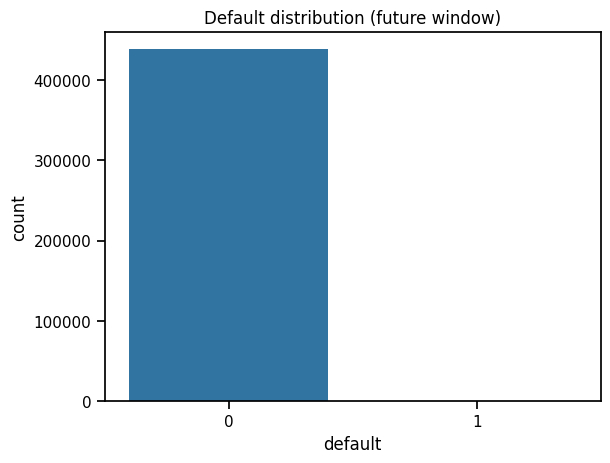

In [22]:
# Age / employment
df_v['AGE_YEARS'] = (-df_v['DAYS_BIRTH'] / 365.25).round(1)
df_v['YEARS_EMPLOYED'] = np.where(df_v['DAYS_EMPLOYED'] < 0,
                                  (-df_v['DAYS_EMPLOYED'] / 365.25),
                                  0.0).round(1)
df_v['IS_UNEMPLOYED'] = (df_v['DAYS_EMPLOYED'] >= 0).astype(int)

# Ratios & bins
df_v['INCOME_PER_MEMBER'] = df_v['AMT_INCOME_TOTAL'] / df_v['CNT_FAM_MEMBERS'].clip(lower=1)
df_v['AGE_BIN'] = pd.cut(df_v['AGE_YEARS'], bins=[18,25,35,45,60,90], labels=False)
df_v['EMP_BIN'] = pd.cut(df_v['YEARS_EMPLOYED'], bins=[0,1,5,10,20,40,60], labels=False)

# Class balance plot
sns.countplot(x='default', data=df_v)
plt.title("Default distribution (future window)")
plt.show()

Train/Test split

In [23]:
from sklearn.model_selection import train_test_split

drop_cols = ['ID','default','DAYS_BIRTH','DAYS_EMPLOYED']  # raw counters we replaced
X = df_v.drop(columns=drop_cols)
y = df_v['default'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
print("Train:", X_train.shape, " Test:", X_test.shape, " Pos rate:", y.mean())

Train: (350808, 30)  Test: (87702, 30)  Pos rate: 0.00039223734920526326


catboost final model

In [24]:
!pip -q install catboost
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, classification_report

# Cat cols -> strings (CatBoost handles categoricals natively)
X_train_cb = X_train.copy(); X_test_cb = X_test.copy()
cat_cols_cb = X_train_cb.select_dtypes(include=['object']).columns.tolist()
X_train_cb[cat_cols_cb] = X_train_cb[cat_cols_cb].fillna("missing").astype(str)
X_test_cb[cat_cols_cb]  = X_test_cb[cat_cols_cb].fillna("missing").astype(str)
cat_idx = [X_train_cb.columns.get_loc(c) for c in cat_cols_cb]

train_pool = Pool(X_train_cb, y_train, cat_features=cat_idx)
test_pool  = Pool(X_test_cb,  y_test,  cat_features=cat_idx)

# imbalance weight
pos, neg = int(y_train.sum()), int((y_train==0).sum())
scale_pos = neg / max(pos,1)
print("scale_pos_weight:", round(scale_pos,1))

cb = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="AUC",
    iterations=2000,
    depth=6,
    learning_rate=0.05,
    l2_leaf_reg=3.0,
    random_seed=42,
    scale_pos_weight=scale_pos,
    early_stopping_rounds=200,
    verbose=200
)
cb.fit(train_pool, eval_set=test_pool)

y_cb = cb.predict_proba(test_pool)[:,1]
roc_cb = roc_auc_score(y_test, y_cb)
pr_cb  = average_precision_score(y_test, y_cb)
print(f"CatBoost ROC-AUC: {roc_cb:.3f} | PR-AUC: {pr_cb:.3f}")

# Threshold tuning → best F1
prec, rec, thr = precision_recall_curve(y_test, y_cb)
thr = np.r_[0.0, thr]
f1 = 2*(prec*rec)/(prec+rec+1e-9)
best = int(np.nanargmax(f1))
best_thr = float(thr[best])
print("Best threshold:", best_thr)
y_hat_cb = (y_cb >= best_thr).astype(int)
print(classification_report(y_test, y_hat_cb, digits=4))

scale_pos_weight: 2541.1
0:	test: 0.9814967	best: 0.9814967 (0)	total: 534ms	remaining: 17m 47s
200:	test: 0.9843054	best: 0.9918550 (56)	total: 1m 35s	remaining: 14m 16s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9918549662
bestIteration = 56

Shrink model to first 57 iterations.
CatBoost ROC-AUC: 0.992 | PR-AUC: 0.303
Best threshold: 0.9772154130706152
              precision    recall  f1-score   support

           0     0.9998    0.9997    0.9997     87668
           1     0.3514    0.3824    0.3662        34

    accuracy                         0.9995     87702
   macro avg     0.6756    0.6910    0.6830     87702
weighted avg     0.9995    0.9995    0.9995     87702



In [25]:
from sklearn.metrics import roc_curve, precision_recall_curve, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt, pandas as pd, json, os

def summarize(y_true, y_prob, thr):
    y_hat = (y_prob >= thr).astype(int)
    return {
        "ROC-AUC": roc_auc_score(y_true, y_prob),
        "PR-AUC": average_precision_score(y_true, y_prob),
        "Precision": precision_score(y_true, y_hat, zero_division=0),
        "Recall": recall_score(y_true, y_hat, zero_division=0),
        "F1": f1_score(y_true, y_hat, zero_division=0),
        "Threshold": thr
    }

# Choose thresholds for LR/BRF similar to best-F1
def best_thr(y_true, y_prob):
    p,r,t = precision_recall_curve(y_true, y_prob)
    t = np.r_[0.0, t]
    f1 = 2*p*r/(p+r+1e-9)
    i = int(np.nanargmax(f1))
    return float(t[i])

thr_lr  = best_thr(y_test, y_lr)  if 'y_lr'  in globals() else None
thr_brf = best_thr(y_test, y_brf) if 'y_brf' in globals() else None
thr_cb  = best_thr

summary = {}
if 'y_lr' in globals():   summary["LogReg(balanced)"] = summarize(y_test, y_lr,  thr_lr)
if 'y_brf' in globals():  summary["BalancedRF"]       = summarize(y_test, y_brf, thr_brf)
summary["CatBoost"] = summarize(y_test, y_cb, best_thr(y_test, y_cb))
summary_df = pd.DataFrame(summary).T
display(summary_df)

# Save artifacts
os.makedirs("results", exist_ok=True)
summary_df.to_csv("results/metrics_summary.csv", index=True)

# ROC & PR for CatBoost
fpr,tpr,_ = roc_curve(y_test, y_cb)
plt.figure(); plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'--'); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("CatBoost ROC"); plt.savefig("results/catboost_roc.png", dpi=150); plt.close()

p,r,_ = precision_recall_curve(y_test, y_cb)
plt.figure(); plt.plot(r, p); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("CatBoost Precision-Recall"); plt.savefig("results/catboost_pr.png", dpi=150); plt.close()

print("Saved metrics + plots to results/")

,ROC-AUC,PR-AUC,Precision,Recall,F1,Threshold
CatBoost,0.991855,0.303375,0.351351,0.382353,0.366197,0.977215


Saved metrics + plots to results/
